#### This figure compares metrics of population activity from awake-resting vs. anesthetized

In [1]:
import os
import sys
import json
import time
from datetime import date
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import integrate, signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

In [8]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

### Load subjects from file

In [9]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [10]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)

MOs_superficial
 546655
Experiment type: electrical and sensory stimulation
 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.
MOs_deep
 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.
 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.
SSp_superficial
 571620
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 586466
Experiment type: electri

In [11]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs'

### Load probe data and gather population activity metrics

In [12]:
event_window = [-1.0, 1.0]

integrate_window = [0.0, 0.025]
zthresh = 3 # pop firing rate must exceed mean(baselineFR) + zthresh*std(baselineFR)
alpha = 0.05

time_bin = 0.0001 # size of time bins (s)
bins = np.arange(event_window[0], event_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2
sigshort = 5 # Gaussian kernel length (Butovas&Schwarz2003 use short kernel for first excitatory response)
# siglong = 50 # Gaussian kernel length (Butovas&Schwarz2003 use long kernel for rest of response)

current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

# Gather data for all subjects and all units (RS & FS)

In [13]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log and running signal ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        run_signal, run_timestamps = mdata['exp'].load_running()
        
        ## Load probe data ##
        probe_list = [x.replace('_sorted', '') for x in mdata['exp'].experiment_data if 'probe' in x]
        probe_popspiketimes = {key: [] for key in list(areas_of_interest.keys())}
        for probei in probe_list:
            ## Select units and get peak chs ##
            select_units, peak_chs, unit_metrics = mdata['exp'].get_probe_units(probei)
            unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
            ## Sort units ##
            all_units = select_units[np.squeeze(np.argsort(peak_chs))]
            all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
            all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
            if 'area' in unit_metrics.columns:
                all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
            else:
                print('  {} unit metrics file does not have area assignments.'.format(probei))
                continue
            ## Load spike times and cluster ids ##
            probe_spike_times = np.load(mdata['exp'].ephys_params[probei]['spike_times'])
            probe_spike_clusters = np.load(mdata['exp'].ephys_params[probei]['spike_clusters'])
            
            ## Loop through units to create population groups ##
            for unitind, uniti in enumerate(all_units):
                spikesi = np.squeeze(probe_spike_times[probe_spike_clusters == uniti])
                parent_region = [key for key in list(areas_of_interest.keys()) if all_units_areas[unitind] in areas_of_interest[key]]
                if len(parent_region) == 1:
                    probe_popspiketimes[parent_region[0]].append(spikesi)
        
        ## Simplify population spike times ##            
        pop_spikes = {}
        total_units = 0
        for region in probe_popspiketimes.keys():
            print('  {}: {:d} units'.format(region, len(probe_popspiketimes[region])))
            if len(probe_popspiketimes[region]) > 5: # unit number threshold
                pop_spikes[region] = {}
                pop_spikes[region]['units'] = len(probe_popspiketimes[region])
                pop_spikes[region]['spike_times'] = np.concatenate(probe_popspiketimes[region])
                total_units += len(probe_popspiketimes[region])
        del probe_popspiketimes
        if total_units == 0:
            print(' No units in areas of interest, not analyzing.\n')
            continue
        
        ## Get trial times ##
        all_event_times = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_times[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if sweeps:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    state_events = np.concatenate(state_events)
                    ## Get mean speed ##
                    rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
                    event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
                    mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
                    all_event_times[leveli][statei] = state_events[mean_speed == 0]
        
        ## Get population activation ##
        pop_all_SDF = {}
        pop_response_metrics = {}
        for leveli, statesevents in all_event_times.items():
            pop_all_SDF[leveli] = {}
            pop_response_metrics[leveli] = {}
            for statei, events in statesevents.items():
                print(' {} stim - {}: {:d} trials'.format(leveli, statei, len(events)))
                pop_all_SDF[leveli][statei] = {}
                pop_response_metrics[leveli][statei] = {}
                ## Loop through regions to get event-related population spikes ##
                for region in pop_spikes.keys():
                    pop_all_SDF[leveli][statei][region] = [] # {}
                    SDF_short = np.zeros((len(events), len(timex)), dtype=float)
#                     SDF_long = np.zeros((len(events), len(timex)), dtype=float)
                    region_spikes = pop_spikes[region]['spike_times']
                    trial_blfr = np.zeros((len(events)), dtype=float)
                    trial_response = np.zeros((len(events)), dtype=bool)
                    response_start = np.zeros((len(events)), dtype=float)
                    peak_FR = np.zeros((len(events)), dtype=float)
                    peak_time = np.zeros((len(events)), dtype=float)
                    response_mag = np.zeros((len(events)), dtype=float)
                    for ii, (eventi) in enumerate(events):
                        spikeinds = np.squeeze(np.argwhere(
                            (region_spikes > eventi + event_window[0]) & (region_spikes < eventi + event_window[1])
                        ))
                        spcounts, edges = np.histogram(region_spikes[spikeinds] - eventi, bins)
                        SDF_short[ii] = (ndimage.gaussian_filter(
                            spcounts, sigma=sigshort, output=float)/(time_bin*pop_spikes[region]['units']))
#                         SDF_long[ii] = (ndimage.gaussian_filter(
#                             spcounts, sigma=siglong, output=float)/(time_bin*pop_spikes[region]['units']))

                        ## Evaluate peak SDF for each trial ##
                        popSDF = SDF_short[ii]
                        intinds = np.nonzero((timex >= integrate_window[0]) & (timex <= integrate_window[1]))[0]
                        FRthresh = np.mean(popSDF[timex < 0]) + zthresh * np.std(popSDF[timex < 0])
                        trial_blfr[ii] = np.mean(popSDF[timex < 0])
                        peaks, props = signal.find_peaks(popSDF[intinds], height=FRthresh)
                        if len(peaks) > 0:
                            trial_response[ii] = True
                            ## Find threshold crossing time ##
                            response_start[ii] = timex[intinds[np.argwhere(popSDF[intinds] > FRthresh)[0][0]]]
                            ## Find peak value and time ##
                            maxind = np.argmax(popSDF[intinds[peaks]])
                            peak_time[ii] = timex[intinds[peaks[maxind]]]
                            peak_FR[ii] = popSDF[intinds[peaks[maxind]]]
                            ## Measure AUC of popFR above FRthresh ##
                            SDF_over_thresh = np.where((popSDF - FRthresh) < 0, 0.0, (popSDF - FRthresh))
                            response_mag[ii] = integrate.simps(SDF_over_thresh[intinds], timex[intinds], axis=0, even='last')
                        else:
                            trial_response[ii] = False
                            response_start[ii] = np.nan
                            peak_time[ii] = np.nan
                            peak_FR[ii] = np.nan
                            response_mag[ii] = np.nan

                    pop_all_SDF[leveli][statei][region] = [timex, SDF_short]
#                     pop_all_SDF[expdes][parami][statei][region]['short'] = [timex, SDF_short]
#                     pop_all_SDF[expdes][parami][statei][region]['long'] = [timex, SDF_long]
                    pop_response_metrics[leveli][statei][region] = pd.DataFrame({
                        'trial': np.arange(len(events)),
                        'avg_blfr': trial_blfr,
                        'response': trial_response,
                        'response_latency': response_start,
                        'response_peak_latency': peak_time,
                        'peak_firing_rate': peak_FR,
                        'response_magnitude': response_mag,
                    })
                
        mdata['pop_SDF'] = pop_all_SDF
        mdata['pop_response_metrics'] = pop_response_metrics
        
        ### After each subject, delete common variables ###
        del stim_log
        del run_signal
        del run_timestamps
        del pop_spikes
        del all_event_times
        del pop_all_SDF
        del pop_response_metrics
        print('')

MOs_superficial

 546655
  MO: 18 units
  ACA: 0 units
  SS: 0 units
  VIS: 9 units
  MO-TH: 30 units
 low stim - awake: 40 trials
 low stim - anesthetized: 117 trials
 medium stim - awake: 40 trials
 medium stim - anesthetized: 108 trials
 high stim - awake: 38 trials
 high stim - anesthetized: 72 trials

 575102
  MO: 15 units
  ACA: 33 units
  SS: 0 units
  VIS: 71 units
  MO-TH: 0 units
 low stim - awake: 84 trials
 low stim - anesthetized: 120 trials
 medium stim - awake: 83 trials
 medium stim - anesthetized: 120 trials
 high stim - awake: 90 trials
 high stim - anesthetized: 120 trials

 571619
  MO: 103 units
  ACA: 154 units
  SS: 14 units
  VIS: 60 units
  MO-TH: 62 units
 low stim - awake: 90 trials
 low stim - anesthetized: 120 trials
 medium stim - awake: 89 trials
 medium stim - anesthetized: 119 trials
 high stim - awake: 94 trials
 high stim - anesthetized: 120 trials

MOs_deep

 551399
  MO: 99 units
  ACA: 19 units
  SS: 120 units
  VIS: 0 units
  MO-TH: 82 units
 low

## Need to get data across subjects

In [31]:
regional_metrics = {}
for region in areas_of_interest:
    group_list = []
    mouse_list = []
    clevel_list = []
    state_list = []
    blfr_list = []
    blfr_sem_list = []
    fraction_list = []
    peakfr_list = []
    peak_sem_list = []
    respmag_list = []
    for group, group_subs in multi_sub_dict.items():
        for mouse_num, mdata in group_subs.items():
            for leveli in current_levels:
                for statei in test_states:
                    try:
                        metricsdf = mdata['pop_response_metrics'][leveli][statei][region]
                    except KeyError:
                        continue
                    group_list.append(group)
                    mouse_list.append(mouse_num)
                    clevel_list.append(leveli)
                    state_list.append(statei)
                    blfr_list.append(np.mean(metricsdf.avg_blfr.values))
                    blfr_sem_list.append(np.std(metricsdf.avg_blfr.values) / np.sqrt(len(metricsdf.avg_blfr.values)))
                    fraction_list.append(np.sum(metricsdf.response.values) / len(metricsdf.response.values))
                    peakfr_list.append(np.nanmean(metricsdf.peak_firing_rate.values))
                    peak_sem_list.append(
                        np.nanstd(metricsdf.peak_firing_rate.values) / np.sqrt(np.sum(~np.isnan(metricsdf.peak_firing_rate.values)))
                    )
                    respmag_list.append(np.nanmean(metricsdf.response_magnitude.values))
    regional_metrics[region] = pd.DataFrame({
        'group': group_list,
        'mouse': mouse_list,
        'stim_level': clevel_list,
        'state': state_list,
        'avg_blfr': blfr_list,
        'sem_blfr': blfr_sem_list,
        'response_fraction': fraction_list,
        'peak_firing_rate': peakfr_list,
        'peak_sem': peak_sem_list,
        'response_magnitude': respmag_list,
    })

### Assemble the figure

In [15]:
blocs = np.arange((len(test_states) + 1) * len(areas_of_interest))
blocs = blocs.reshape((len(areas_of_interest), (len(test_states) + 1)))

plt.rc('ytick',labelsize=8)

<IPython.core.display.Javascript object>


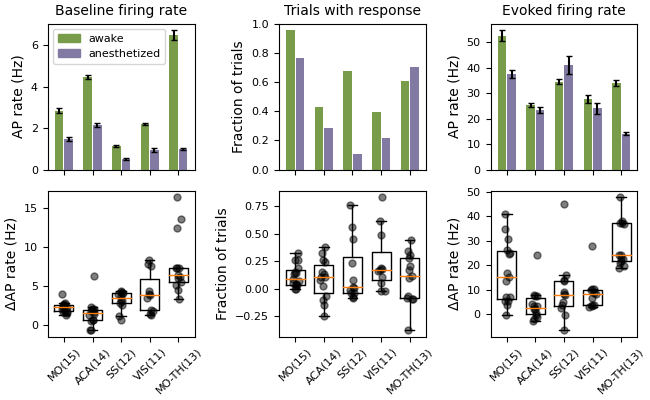

In [95]:
## Figure with awake-anesthetized ##
exgroup = 'MOs_deep'
exmouse = '569073'
plot_level = 'medium'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6.5,4), sharex=True, constrained_layout=True)

reg_labels = []
for ri, (region, regdf) in enumerate(regional_metrics.items()):
    blfrs = []
    resp_fr = []
    pfr = []
    for jj, statei in enumerate(test_states):
        exampledf = regdf[
            (regdf['group']==exgroup) & (regdf['mouse']==exmouse) & (regdf['stim_level']==plot_level) & (regdf['state']==statei)
        ]
        mstatedf = regdf[(regdf['stim_level']==plot_level) & (regdf['state']==statei)]
        xloc = blocs[ri, jj]
        ## Plot for single subject ##
        axs[0,0].bar(
            xloc, exampledf['avg_blfr'].values, yerr=exampledf['sem_blfr'].values, width=0.9, color=state_colors[statei]
        )
        axs[0,1].bar(xloc, exampledf['response_fraction'].values, width=0.9, color=state_colors[statei])
        axs[0,2].bar(
            xloc, exampledf['peak_firing_rate'].values, yerr=exampledf['peak_sem'].values,
            width=0.9, color=state_colors[statei]
        )
        
        ## Plot for multi-subject ##
        blfrs.append(mstatedf['avg_blfr'].values)
        resp_fr.append(mstatedf['response_fraction'].values)
        pfr.append(mstatedf['peak_firing_rate'].values)
    
    xposi = np.mean(blocs[ri,:-1])
    xs = np.random.normal(xposi, 0.2, len(mstatedf))
    delta_blfr = blfrs[0] - blfrs[1]
    delta_fract = resp_fr[0] - resp_fr[1]
    delta_peak = pfr[0] - pfr[1]
    
    axs[1,0].boxplot(delta_blfr, positions=[xposi], widths=[2], showfliers=False)
    axs[1,0].scatter(xs, delta_blfr, c='k', marker='o', s=25, alpha=0.5)
    axs[1,1].boxplot(delta_fract, positions=[xposi], widths=[2], showfliers=False)
    axs[1,1].scatter(xs, delta_fract, c='k', marker='o', s=25, alpha=0.5)
    axs[1,2].boxplot(delta_peak, positions=[xposi], widths=[2], showfliers=False)
    axs[1,2].scatter(xs, delta_peak, c='k', marker='o', s=25, alpha=0.5)
    
    reg_labels.append('{}({:d})'.format(region, len(mstatedf)))
    
## Set x-axis labels ##
axs[1,0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1,0].set_xticklabels(reg_labels, fontsize=8, rotation=45)
axs[1,1].set_xticklabels(reg_labels, fontsize=8, rotation=45)
axs[1,2].set_xticklabels(reg_labels, fontsize=8, rotation=45)

## Set y-axis labels ##
axs[0,0].set_ylabel('AP rate (Hz)')
axs[1,0].set_ylabel('\u0394AP rate (Hz)')
axs[0,1].set_ylabel('Fraction of trials')
axs[1,1].set_ylabel('Fraction of trials')
axs[0,2].set_ylabel('AP rate (Hz)')
axs[1,2].set_ylabel('\u0394AP rate (Hz)')

## Set titles ##
axs[0,0].set_title('Baseline firing rate')
axs[0,1].set_title('Trials with response')
axs[0,2].set_title('Evoked firing rate')

## Make a legend ##
barhandles = []
for jj, statei in enumerate(test_states):
    barhandles.append(Patch(color=state_colors[statei], label=statei))
axs[0,0].legend(handles=barhandles, prop={'size': 8})

## Save ##
figname = 'Figure5_popmetrics_allpops_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Plot multi-subject metrics

Plot baseline firing rate

Plot fraction of trials with response

Plot peak response firing rate

# Gather data for all subjects and RS units only

In [13]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        
        ## Grab exp metadata from Zap_Zip-log_exp ##
        exp_meta = zzmetadata[(
            (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
            (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
        )].squeeze()
        currentstr = exp_meta['Current (uA)'].replace(' ','')
        currents_list = []
        for char in currentstr.split('/'):
            if char.isdecimal():
                currents_list.append(char)

        ## Load stim log and running signal ##
        stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
        stim_log = stim_log.astype({'parameter': str})
        run_signal, run_timestamps = mdata['exp'].load_running()
        
        ## Load probe data ##
        probe_list = [x.replace('_sorted', '') for x in mdata['exp'].experiment_data if 'probe' in x]
        probe_popspiketimes = {key: [] for key in list(areas_of_interest.keys())}
        for probei in probe_list:
            ## Select units and get peak chs ##
            select_units, peak_chs, unit_metrics = mdata['exp'].get_probe_units(probei)
            unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
            ## Sort units ##
            all_units = select_units[np.squeeze(np.argsort(peak_chs))]
            all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
            all_units_types = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
            if 'area' in unit_metrics.columns:
                all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
            else:
                print('  {} unit metrics file does not have area assignments.'.format(probei))
                continue
            ## Load spike times and cluster ids ##
            probe_spike_times = np.load(mdata['exp'].ephys_params[probei]['spike_times'])
            probe_spike_clusters = np.load(mdata['exp'].ephys_params[probei]['spike_clusters'])
            
            ## Loop through units to create population groups ##
            for unitind, uniti in enumerate(all_units):
                spikesi = np.squeeze(probe_spike_times[probe_spike_clusters == uniti])
                parent_region = [key for key in list(areas_of_interest.keys()) if all_units_areas[unitind] in areas_of_interest[key]]
                if (len(parent_region) == 1) and (all_units_types[unitind] == 'RS'):
                    probe_popspiketimes[parent_region[0]].append(spikesi)
        ## Simplify population spike times ##            
        pop_spikes = {}
        total_units = 0
        for region in probe_popspiketimes.keys():
            print('  {}: {:d} RS units'.format(region, len(probe_popspiketimes[region])))
            if len(probe_popspiketimes[region]) > 5: # unit number threshold
                pop_spikes[region] = {}
                pop_spikes[region]['units'] = len(probe_popspiketimes[region])
                pop_spikes[region]['spike_times'] = np.concatenate(probe_popspiketimes[region])
                total_units += len(probe_popspiketimes[region])
        del probe_popspiketimes
        if total_units == 0:
            print(' No units in areas of interest, not analyzing.\n')
            continue
        
        ## Get trial times ##
        all_event_times = {}
        for leveli, parami in zip(current_levels, currents_list):
            all_event_times[leveli] = {}
            for statei in test_states:
                sweeps = mdata['states'][statei]
                if sweeps:
                    state_events = []
                    for sweepi in sweeps:
                        events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                        if len(events) == 0:
                            continue
                        state_events.append(events)
                    state_events = np.concatenate(state_events)
                    ## Get mean speed ##
                    rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
                    event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
                    mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
                    all_event_times[leveli][statei] = state_events[mean_speed == 0]
        
        ## Get population activation ##
        pop_all_SDF = {}
        pop_response_metrics = {}
        for leveli, statesevents in all_event_times.items():
            pop_all_SDF[leveli] = {}
            pop_response_metrics[leveli] = {}
            for statei, events in statesevents.items():
                print(' {} stim - {}: {:d} trials'.format(leveli, statei, len(events)))
                pop_all_SDF[leveli][statei] = {}
                pop_response_metrics[leveli][statei] = {}
                ## Loop through regions to get event-related population spikes ##
                for region in pop_spikes.keys():
                    pop_all_SDF[leveli][statei][region] = [] # {}
                    SDF_short = np.zeros((len(events), len(timex)), dtype=float)
#                     SDF_long = np.zeros((len(events), len(timex)), dtype=float)
                    region_spikes = pop_spikes[region]['spike_times']
                    trial_blfr = np.zeros((len(events)), dtype=float)
                    trial_response = np.zeros((len(events)), dtype=bool)
                    response_start = np.zeros((len(events)), dtype=float)
                    peak_FR = np.zeros((len(events)), dtype=float)
                    peak_time = np.zeros((len(events)), dtype=float)
                    response_mag = np.zeros((len(events)), dtype=float)
                    for ii, (eventi) in enumerate(events):
                        spikeinds = np.squeeze(np.argwhere(
                            (region_spikes > eventi + event_window[0]) & (region_spikes < eventi + event_window[1])
                        ))
                        spcounts, edges = np.histogram(region_spikes[spikeinds] - eventi, bins)
                        SDF_short[ii] = (ndimage.gaussian_filter(
                            spcounts, sigma=sigshort, output=float)/(time_bin*pop_spikes[region]['units']))
#                         SDF_long[ii] = (ndimage.gaussian_filter(
#                             spcounts, sigma=siglong, output=float)/(time_bin*pop_spikes[region]['units']))

                        ## Evaluate peak SDF for each trial ##
                        popSDF = SDF_short[ii]
                        intinds = np.nonzero((timex >= integrate_window[0]) & (timex <= integrate_window[1]))[0]
                        FRthresh = np.mean(popSDF[timex < 0]) + zthresh * np.std(popSDF[timex < 0])
                        trial_blfr[ii] = np.mean(popSDF[timex < 0])
                        peaks, props = signal.find_peaks(popSDF[intinds], height=FRthresh)
                        if len(peaks) > 0:
                            trial_response[ii] = True
                            ## Find threshold crossing time ##
                            response_start[ii] = timex[intinds[np.argwhere(popSDF[intinds] > FRthresh)[0][0]]]
                            ## Find peak value and time ##
                            maxind = np.argmax(popSDF[intinds[peaks]])
                            peak_time[ii] = timex[intinds[peaks[maxind]]]
                            peak_FR[ii] = popSDF[intinds[peaks[maxind]]]
                            ## Measure AUC of popFR above FRthresh ##
                            SDF_over_thresh = np.where((popSDF - FRthresh) < 0, 0.0, (popSDF - FRthresh))
                            response_mag[ii] = integrate.simps(SDF_over_thresh[intinds], timex[intinds], axis=0, even='last')
                        else:
                            trial_response[ii] = False
                            response_start[ii] = np.nan
                            peak_time[ii] = np.nan
                            peak_FR[ii] = np.nan
                            response_mag[ii] = np.nan

                    pop_all_SDF[leveli][statei][region] = [timex, SDF_short]
#                     pop_all_SDF[expdes][parami][statei][region]['short'] = [timex, SDF_short]
#                     pop_all_SDF[expdes][parami][statei][region]['long'] = [timex, SDF_long]
                    pop_response_metrics[leveli][statei][region] = pd.DataFrame({
                        'trial': np.arange(len(events)),
                        'avg_blfr': trial_blfr,
                        'response': trial_response,
                        'response_latency': response_start,
                        'response_peak_latency': peak_time,
                        'peak_firing_rate': peak_FR,
                        'response_magnitude': response_mag,
                    })
                
        mdata['pop_SDF'] = pop_all_SDF
        mdata['pop_response_metrics'] = pop_response_metrics
        
        ### After each subject, delete common variables ###
        del stim_log
        del run_signal
        del run_timestamps
        del pop_spikes
        del all_event_times
        del pop_all_SDF
        del pop_response_metrics
        print('')

MOs_superficial

 546655
  MO: 18 RS units
  ACA: 0 RS units
  SS: 0 RS units
  VIS: 5 RS units
  MO-TH: 3 RS units
 low stim - awake: 40 trials
 low stim - anesthetized: 117 trials
 medium stim - awake: 40 trials
 medium stim - anesthetized: 108 trials
 high stim - awake: 38 trials
 high stim - anesthetized: 72 trials

 575102
  MO: 12 RS units
  ACA: 27 RS units
  SS: 0 RS units
  VIS: 59 RS units
  MO-TH: 0 RS units
 low stim - awake: 84 trials
 low stim - anesthetized: 120 trials
 medium stim - awake: 83 trials
 medium stim - anesthetized: 120 trials
 high stim - awake: 90 trials
 high stim - anesthetized: 120 trials

 571619
  MO: 95 RS units
  ACA: 138 RS units
  SS: 12 RS units
  VIS: 47 RS units
  MO-TH: 53 RS units
 low stim - awake: 90 trials
 low stim - anesthetized: 120 trials
 medium stim - awake: 89 trials
 medium stim - anesthetized: 119 trials
 high stim - awake: 94 trials
 high stim - anesthetized: 120 trials

MOs_deep

 551399
  MO: 89 RS units
  ACA: 15 RS units
  SS

## Accumulate data across subjects

In [14]:
regional_metrics = {}
for region in areas_of_interest:
    group_list = []
    mouse_list = []
    clevel_list = []
    state_list = []
    blfr_list = []
    blfr_sem_list = []
    fraction_list = []
    peakfr_list = []
    peak_sem_list = []
    respmag_list = []
    for group, group_subs in multi_sub_dict.items():
        for mouse_num, mdata in group_subs.items():
#             print(mouse_num)
            for leveli in current_levels:
                for statei in test_states:
                    try:
                        metricsdf = mdata['pop_response_metrics'][leveli][statei][region]
                    except KeyError:
                        continue
                    group_list.append(group)
                    mouse_list.append(mouse_num)
                    clevel_list.append(leveli)
                    state_list.append(statei)
                    blfr_list.append(np.mean(metricsdf.avg_blfr.values))
                    blfr_sem_list.append(np.std(metricsdf.avg_blfr.values) / np.sqrt(len(metricsdf.avg_blfr.values)))
                    fraction_list.append(np.sum(metricsdf.response.values) / len(metricsdf.response.values))
                    if np.sum(metricsdf.response.values) > 0:
                        peakfr_list.append(np.nanmean(metricsdf.peak_firing_rate.values))
                        peak_sem_list.append(
                            np.nanstd(metricsdf.peak_firing_rate.values) / np.sqrt(np.sum(~np.isnan(metricsdf.peak_firing_rate.values)))
                        )
                        respmag_list.append(np.nanmean(metricsdf.response_magnitude.values))
                    else:
                        peakfr_list.append(np.nan)
                        peak_sem_list.append(np.nan)
                        respmag_list.append(np.nan)
    regional_metrics[region] = pd.DataFrame({
        'group': group_list,
        'mouse': mouse_list,
        'stim_level': clevel_list,
        'state': state_list,
        'avg_blfr': blfr_list,
        'sem_blfr': blfr_sem_list,
        'response_fraction': fraction_list,
        'peak_firing_rate': peakfr_list,
        'peak_sem': peak_sem_list,
        'response_magnitude': respmag_list,
    })

### Assemble the figure

In [16]:
blocs = np.arange((len(test_states) + 1) * len(areas_of_interest))
blocs = blocs.reshape((len(areas_of_interest), (len(test_states) + 1)))

plt.rc('ytick', labelsize=8)

<IPython.core.display.Javascript object>


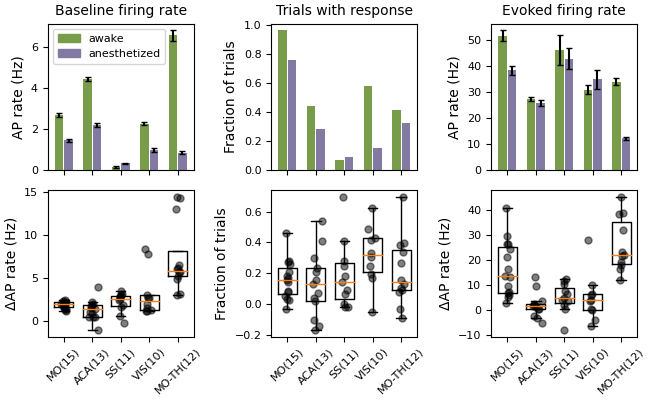

In [28]:
## Figure with awake-anesthetized ##
exgroup = 'MOs_deep'
exmouse = '569073'
plot_level = 'medium'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6.5,4), sharex=True, constrained_layout=True)

reg_labels = []
for ri, (region, regdf) in enumerate(regional_metrics.items()):
    blfrs = []
    resp_fr = []
    pfr = []
    for jj, statei in enumerate(test_states):
        exampledf = regdf[
            (regdf['group']==exgroup) & (regdf['mouse']==exmouse) & (regdf['stim_level']==plot_level) & (regdf['state']==statei)
        ]
        mstatedf = regdf[(regdf['stim_level']==plot_level) & (regdf['state']==statei)]
        xloc = blocs[ri, jj]
        ## Plot for single subject ##
        axs[0,0].bar(
            xloc, exampledf['avg_blfr'].values, yerr=exampledf['sem_blfr'].values, width=0.9, color=state_colors[statei]
        )
        axs[0,1].bar(xloc, exampledf['response_fraction'].values, width=0.9, color=state_colors[statei])
        axs[0,2].bar(
            xloc, exampledf['peak_firing_rate'].values, yerr=exampledf['peak_sem'].values,
            width=0.9, color=state_colors[statei]
        )
        
        ## Plot for multi-subject ##
        blfrs.append(mstatedf['avg_blfr'].values)
        resp_fr.append(mstatedf['response_fraction'].values)
        pfr.append(mstatedf['peak_firing_rate'].values)
    
    xposi = np.mean(blocs[ri,:-1])
    xs = np.random.normal(xposi, 0.2, len(mstatedf))
    delta_blfr = blfrs[0] - blfrs[1]
    delta_fract = resp_fr[0] - resp_fr[1]
    delta_peak = pfr[0] - pfr[1]
    
    axs[1,0].boxplot(delta_blfr, positions=[xposi], widths=[2], showfliers=False)
    axs[1,0].scatter(xs, delta_blfr, c='k', marker='o', s=25, alpha=0.5)
    axs[1,1].boxplot(delta_fract, positions=[xposi], widths=[2], showfliers=False)
    axs[1,1].scatter(xs, delta_fract, c='k', marker='o', s=25, alpha=0.5)
    axs[1,2].boxplot(delta_peak[~np.isnan(delta_peak)], positions=[xposi], widths=[2], showfliers=False)
    axs[1,2].scatter(xs, delta_peak, c='k', marker='o', s=25, alpha=0.5)
    
    reg_labels.append('{}({:d})'.format(region, len(mstatedf)))
    
## Set x-axis labels ##
axs[1,0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1,0].set_xticklabels(reg_labels, fontsize=8, rotation=45)
axs[1,1].set_xticklabels(reg_labels, fontsize=8, rotation=45)
axs[1,2].set_xticklabels(reg_labels, fontsize=8, rotation=45)

## Set y-axis labels ##
axs[0,0].set_ylabel('AP rate (Hz)')
axs[1,0].set_ylabel('\u0394AP rate (Hz)')
axs[0,1].set_ylabel('Fraction of trials')
axs[1,1].set_ylabel('Fraction of trials')
axs[0,2].set_ylabel('AP rate (Hz)')
axs[1,2].set_ylabel('\u0394AP rate (Hz)')

## Set titles ##
axs[0,0].set_title('Baseline firing rate')
axs[0,1].set_title('Trials with response')
axs[0,2].set_title('Evoked firing rate')

## Make a legend ##
barhandles = []
for jj, statei in enumerate(test_states):
    barhandles.append(Patch(color=state_colors[statei], label=statei))
axs[0,0].legend(handles=barhandles, prop={'size': 8})

## Save ##
figname = 'Figure5_popmetrics_allpops_RSonly_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

In [25]:
reg_labels0

['MO(15)', 'ACA(13)', 'SS(11)', 'VIS(10)', 'MO-TH(12)']

# Accumulate data across subjects, cortex only: stim and non-stim

In [108]:
ctx_regions = ['MO', 'ACA', 'SS', 'VIS']

group_list = []
mouse_list = []
reg_list = []
stim_ctx = []
clevel_list = []
state_list = []
blfr_list = []
blfr_sem_list = []
fraction_list = []
peakfr_list = []
peak_sem_list = []
respmag_list = []
for group, group_subs in multi_sub_dict.items():
    stim_area = group[:2]
    for region in ctx_regions:
        for mouse_num, mdata in group_subs.items():
#             print(mouse_num)
            for leveli in current_levels:
                for statei in test_states:
                    try:
                        metricsdf = mdata['pop_response_metrics'][leveli][statei][region]
                    except KeyError:
                        continue
                    group_list.append(group)
                    mouse_list.append(mouse_num)
                    reg_list.append(region)
                    stim_ctx.append(region == stim_area)
                    clevel_list.append(leveli)
                    state_list.append(statei)
                    blfr_list.append(np.mean(metricsdf.avg_blfr.values))
                    blfr_sem_list.append(np.std(metricsdf.avg_blfr.values)) # / np.sqrt(len(metricsdf.avg_blfr.values)))
                    fraction_list.append(np.sum(metricsdf.response.values) / len(metricsdf.response.values))
                    if np.sum(metricsdf.response.values) > 0:
                        peakfr_list.append(np.nanmean(metricsdf.peak_firing_rate.values))
                        peak_sem_list.append(
                            np.nanstd(metricsdf.peak_firing_rate.values) # / np.sqrt(np.sum(~np.isnan(metricsdf.peak_firing_rate.values)))
                        )
                        respmag_list.append(np.nanmean(metricsdf.response_magnitude.values))
                    else:
                        peakfr_list.append(np.nan)
                        peak_sem_list.append(np.nan)
                        respmag_list.append(np.nan)
megadf = pd.DataFrame({
    'group': group_list,
    'mouse': mouse_list,
    'region': reg_list,
    'stim_cortex': stim_ctx,
    'stim_level': clevel_list,
    'state': state_list,
    'avg_blfr': blfr_list,
    'sem_blfr': blfr_sem_list,
    'response_fraction': fraction_list,
    'peak_firing_rate': peakfr_list,
    'peak_sem': peak_sem_list,
    'response_magnitude': respmag_list,
})

popmetrics = {
    'stim': megadf[megadf['stim_cortex'] == True],
    'nonstim': megadf[megadf['stim_cortex'] == False],
}

### Assemble the figure

In [37]:
blocs = np.arange((len(test_states) + 1) * len(popmetrics))
blocs = blocs.reshape((len(popmetrics), (len(test_states) + 1)))

plt.rc('ytick',labelsize=8)

<IPython.core.display.Javascript object>


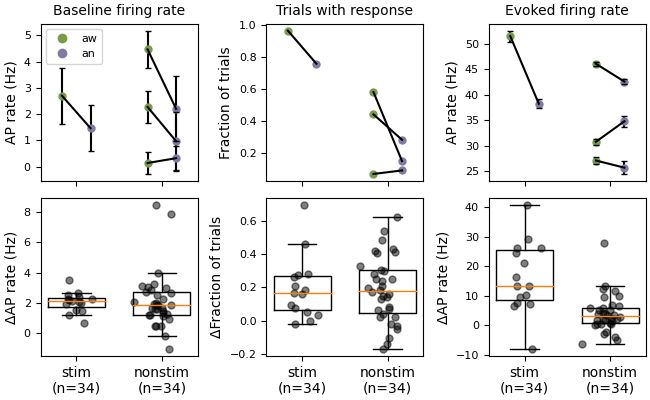

In [114]:
## Figure with awake-anesthetized, stim vs nonstim ##
exgroup = 'MOs_deep'
exmouse = '569073'
plot_level = 'medium'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6.5,4), sharex=True, constrained_layout=True)

reg_labels = []
for ri, (ctxi, regdf) in enumerate(popmetrics.items()):
    sing_bl, sing_blsem = [], []
    sing_fr = []
    sing_pk, sing_pksem = [], []
    blfrs, resp_fr, pfr = [], [], []
    for jj, statei in enumerate(test_states):
        exampledf = regdf[(
            (regdf['group']==exgroup) & (regdf['mouse']==exmouse) &
            (regdf['stim_level']==plot_level) & (regdf['state']==statei)
        )]
        multidf = regdf[(regdf['stim_level']==plot_level) & (regdf['state']==statei)]
        ## plot for single subject ##
        xlocs = np.full((len(exampledf)), blocs[ri, jj])
        axs[0,0].plot(
            xlocs, exampledf['avg_blfr'].values, color=state_colors[statei], marker='o', markersize=5, linestyle='none'
        )
        sing_bl.append(exampledf['avg_blfr'].values)
        sing_blsem.append(exampledf['sem_blfr'].values)
        axs[0,1].plot(
            xlocs, exampledf['response_fraction'].values, color=state_colors[statei],
            marker='o', markersize=5, linestyle='none'
        )
        sing_fr.append(exampledf['response_fraction'].values)
        axs[0,2].plot(
            xlocs, exampledf['peak_firing_rate'].values, color=state_colors[statei],
            marker='o', markersize=5, linestyle='none'
        )
        sing_pk.append(exampledf['peak_firing_rate'].values)
        sing_pksem.append(exampledf['sem_blfr'].values)
        
        ## Plot for multi-subject ##
        blfrs.append(multidf['avg_blfr'].values)
        resp_fr.append(multidf['response_fraction'].values)
        pfr.append(multidf['peak_firing_rate'].values)
        
    ## plot lines for single subject ##
    for ii in range(np.array(sing_bl).shape[1]):
        axs[0,0].errorbar(blocs[ri,:-1], np.array(sing_bl)[:,ii], yerr=np.array(sing_blsem)[:,ii], color='k')
        axs[0,1].plot(blocs[ri,:-1], np.array(sing_fr)[:,ii], color='k')
        axs[0,2].errorbar(blocs[ri,:-1], np.array(sing_pk)[:,ii], yerr=np.array(sing_pksem)[:,ii], color='k')
    
    ## plot multisubject ##
    xposi = np.mean(blocs[ri,:-1])
    delta_blfr = blfrs[0] - blfrs[1]
    delta_fract = resp_fr[0] - resp_fr[1]
    delta_peak = pfr[0] - pfr[1]
    xs = np.random.normal(xposi, 0.3, len(delta_blfr))
    
    axs[1,0].boxplot(delta_blfr, positions=[xposi], widths=[2], showfliers=False)
    axs[1,0].scatter(xs, delta_blfr, c='k', marker='o', s=25, alpha=0.5)
    axs[1,1].boxplot(delta_fract, positions=[xposi], widths=[2], showfliers=False)
    axs[1,1].scatter(xs, delta_fract, c='k', marker='o', s=25, alpha=0.5)
    axs[1,2].boxplot(delta_peak[~np.isnan(delta_peak)], positions=[xposi], widths=[2], showfliers=False)
    axs[1,2].scatter(xs, delta_peak, c='k', marker='o', s=25, alpha=0.5)
    
    reg_labels.append('{}\n(n={:d})'.format(ctxi, len(mstatedf)))
    
## Set x-axis labels ##
axs[1,0].set_xticks(np.mean(blocs[:,:-1], axis=1))
axs[1,0].set_xticklabels(reg_labels)
# axs[1,1].set_xticklabels(reg_labels)
# axs[1,2].set_xticklabels(reg_labels)

## Set y-axis labels ##
axs[0,0].set_ylabel('AP rate (Hz)')
axs[1,0].set_ylabel('\u0394AP rate (Hz)')
axs[0,1].set_ylabel('Fraction of trials')
axs[1,1].set_ylabel('\u0394Fraction of trials')
axs[0,2].set_ylabel('AP rate (Hz)')
axs[1,2].set_ylabel('\u0394AP rate (Hz)')

## Set titles ##
axs[0,0].set_title('Baseline firing rate')
axs[0,1].set_title('Trials with response')
axs[0,2].set_title('Evoked firing rate')

## Make a legend ##
barhandles = []
for jj, statei in enumerate(test_states):
    barhandles.append(Line2D([], [], color=state_colors[statei], linestyle='none', marker='o', label=statei[:2]))
axs[0,0].legend(handles=barhandles, prop={'size': 8}, loc='upper left') # , prop={'size': 8}

## Save ##
figname = 'Figure5_ctx_RSonly_allmice_{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)